### Generative Adversarial Network - CIFAR 10

After attempting to create the digits in the MNIST dataset we move further in our quest in creating more realistic images from the **CIFAR-10**. Here, we create the **DCGAN** networks to understand how its different from Vanilla **GAN** structure.

In [15]:
# importing the python packages
# loading the packages
from IPython import display

# logger class from the utils python file -> source (giving full credits to diegoalejogm/gan)
# full interpretaion with comments added by me for better understanding
from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# giving the path to data folder
D_FOLDER = './torch_data/DCGAN/CIFAR'

### Loading Data

We create instances from dataset class for trying different transformation functions.

In [4]:
# compose No transforms
def cifar_data():
    # resize -> convert to tensor -> normalize with mean 0.5 and std 0.5
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    # directory where data needs to be stored
    out_dir = '{}/dataset'.format(D_FOLDER + '_no')
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

# compose randomflips transform
def cifar_data_hflips():
    # RandomHorizontalFlip -> resize -> convert to tensor -> normalize with mean 0.5 and std 0.5
    compose = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    # directory where data needs to be stored
    out_dir = '{}/dataset'.format(D_FOLDER + '_hflips')
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

# compose randomflips transform
def cifar_data_vflips():
    # RandomVerticalFlip -> resize -> convert to tensor -> normalize with mean 0.5 and std 0.5
    compose = transforms.Compose(
        [
            transforms.RandomVerticalFlip(p=0.5),
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    # directory where data needs to be stored
    out_dir = '{}/dataset'.format(D_FOLDER + '_vflips')
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

# compose randomflips transform
def cifar_data_flips():
    # RandomVerticalFlip -> RandomVerticalFlip -> resize -> convert to tensor -> normalize with mean 0.5 and std 0.5
    compose = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    # directory where data needs to be stored
    out_dir = '{}/dataset'.format(D_FOLDER + '_flips')
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

We try to create functions that carry out different set of transformations to test the effect of transforms on image generation.

In [6]:
BATCH_SIZE = 100
SHUFFLE = True

In [7]:
# creating data folder with transformed images
data = cifar_data()
batch_size = BATCH_SIZE
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=SHUFFLE)
num_batches = len(data_loader)

Files already downloaded and verified


### Network Construction

Since we have 2D images, we would want to include **Convolutional filters** in our **Discriminator Network** this time. We would also want to include **Deconvolutional filters** in our **Generator Network** this time.

In [8]:
# Network for Discriminator    
class DiscriminativeNet(torch.nn.Module):
    
    # class directly inherits from the Module class
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),# no bias required in the conv filter
            nn.LeakyReLU(0.2, inplace=True) # Leaky ReLU activation function
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),# no bias required in the conv filter
            nn.BatchNorm2d(256),# batch normalization
            nn.LeakyReLU(0.2, inplace=True) # Leaky ReLU activation function
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),# no bias required in the conv filter
            nn.BatchNorm2d(512),# batch normalization
            nn.LeakyReLU(0.2, inplace=True) # Leaky ReLU activation function
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),# no bias required in the conv filter
            nn.BatchNorm2d(1024),# batch normalization
            nn.LeakyReLU(0.2, inplace=True) # Leaky ReLU activation function
        )
        
        # output sigmoid function that discriminates between real and fake images
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )
        
        
    # forward network for discriminator
    def forward(self, x):
        
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

In [19]:
# Network for Generator 
class GenerativeNet(torch.nn.Module):
    
    # class directly inherits from the Module class
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),# no bias required in the conv filter
            nn.BatchNorm2d(512),# batch normalization
            nn.ReLU(inplace=True) # ReLU activation function
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),# no bias required in the conv filter
            nn.BatchNorm2d(256),# batch normalization
            nn.ReLU(inplace=True) # ReLU activation function
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),# no bias required in the conv filter
            nn.BatchNorm2d(128),# batch normalization
            nn.ReLU(inplace=True) # ReLU activation function
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )# no bias required in the conv filter
        
        # output tanh function
        self.out = torch.nn.Tanh()
        
    # forward network for generator
    def forward(self, x):
        
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Apply Tanh
        return self.out(x)
    
# Function to generate Noise
def noise(size):
    n = Variable(torch.randn(size, BATCH_SIZE)) # uniform distribution noise variable
    # if GPU available use CUDA
    if torch.cuda.is_available():
        return n.cuda()
    return n

In [20]:
# initalizing the weights if variable namespace already not present

WEIGHT_MEAN = 0.00
WEIGHT_STD = 0.02

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(WEIGHT_MEAN, WEIGHT_STD)

In [21]:
# Create Network instances and init weights

# generator network
generator = GenerativeNet()
generator.apply(init_weights)

# discriminator network
discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# if GPU available use CUDA
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

### Optimization

We would want to use the **Adam** optimizer for our network. We define the constants beforehand for this.

In [22]:
# defining contants
LEARNING_RATE = 0.0002
BETAS = (0.5, 0.999)
# Number of epochs
num_epochs = 200

# We define the optimizers for discriminator and generator
d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=BETAS)
g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=BETAS)

# Loss function will Binary Cross Entropy since we have two classes Real and Fake
loss = nn.BCELoss()

### Training 

We begin our training process by creating discriminator and generator network and we differentially train their parameters using the **detach** function.

In [18]:
# functions that return target vector for real and fake images (discriminator will use these 
# labels)

# target variable for real images should be one
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

# target variable for fake images should be zero
def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [23]:
# train the discriminator network 
def train_discriminator(optimizer, real_data, fake_data):

    # Reset gradients
    optimizer.zero_grad()
    
    # Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error on predicting labels for real images
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    # backpropagate
    error_real.backward()

    # Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error on predicting labels for fake images
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    # backpropagate
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return total error, prediction for real images, prediction for fake images
    return error_real + error_fake, prediction_real, prediction_fake

# train the generator network 
def train_generator(optimizer, fake_data):
    
    # Train Generator
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data, pass it through discriminator
    prediction = discriminator(fake_data)
    
    # Calculate error on predicting fake images as real images
    error = loss(prediction, real_data_target(prediction.size(0)))
    # backpropagate
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

#### Generate test noise and see tensor size

In [26]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [27]:
test_noise.size()

torch.Size([16, 100])

In [28]:
test_noise[0]

tensor([ 1.7427,  0.4560, -1.1017,  1.6995, -0.4932, -0.6783,  0.0693, -0.8002,
        -0.6085,  0.2169, -0.3389, -1.7642,  0.8143,  1.2580,  0.6212, -1.8803,
        -1.1810,  2.4535,  0.3151, -0.1561, -0.9410, -0.2257, -2.3037, -0.9548,
        -0.4479, -0.3253, -0.7438, -0.7794, -2.3746,  1.7540, -0.2284,  0.0077,
         0.9208,  2.0850,  1.2391,  0.9548, -1.9631,  0.3498,  1.3775, -0.4047,
        -0.0536, -0.0842,  1.3221, -0.9742, -0.1557,  1.3362, -0.2290, -0.3747,
         1.3496,  1.6111, -1.2486, -1.3436,  0.5073, -1.5503,  0.5179, -1.0849,
         0.1525, -0.0357,  0.8146,  1.8345, -0.5093, -0.7433, -0.6683,  0.7761,
         0.5127,  0.2533, -0.4712, -0.2066,  0.4373, -2.2102, -1.2327,  0.4843,
        -0.9407, -2.5717, -0.8711, -0.3668,  1.0902, -0.6024,  0.1628,  1.0956,
        -0.1441,  1.1735,  0.9874, -1.1002,  1.2869,  1.0165,  0.5194,  0.8538,
        -0.5247,  0.0356, -0.8317,  0.9804,  0.8132, -0.0457, -0.2328,  0.8408,
        -0.0034, -0.3763,  0.0685,  0.43

#### Initiate training loop

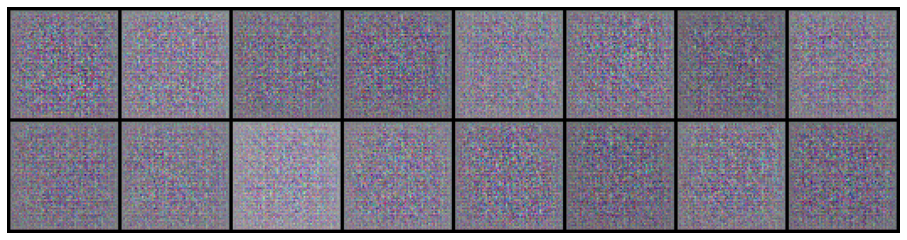

Epoch: [0/200], Batch Num: [0/500]
Discriminator Loss: 1.3859, Generator Loss: 0.7124
D(x): 0.4983, D(G(z)): 0.4981


KeyboardInterrupt: 

In [29]:
# create the instance for logger that will generate checkpoints and tensorboard scalars 
# for display
logger = Logger(model_name='DCGAN', data_name='CIFAR10')

for epoch in range(num_epochs):
    
    # get the batch number
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available():
            real_data = real_data.cuda()
        # Generate fake data, no computation of gradients for generator in this step
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D only
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # Train Generator
        # Generate fake data, computation of gradients for generator available 
        fake_data = generator(noise(real_batch.size(0)))
        # Train G and D
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)